In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from onnxruntime import InferenceSession
from onnxmltools.convert import convert_xgboost
from onnxconverter_common.data_types import FloatTensorType

## 1. Prepare Datasets for Training

First, we need to prepare the datasets we have for training our model that will predict wether or not to give a user a loan. There are three datasets provided
1. ``zipcode``: features regarding census data in certain zipcodes
2. ``credit``: features regarding specific users credit histories
3. ``loan``: feature regarding specific users, where they live and their loan histories.

For training, we need to group all these datasets together and use the ``loan status`` (either 1 for approved or 0 for rejected). The loan dataset has both ``zipcode`` and ``dob_ssn`` so we can use both of those to merge the datasets.


In [2]:
DATA_LOCATION="/data"

In [3]:
zipcode_dataset = pd.read_parquet(f"{DATA_LOCATION}/zipcode_table.parquet")
credit_dataset = pd.read_parquet(f"{DATA_LOCATION}/credit_history.parquet")
loan_dataset = pd.read_parquet(f"{DATA_LOCATION}/loan_table.parquet")

zipcode_dataset = zipcode_dataset.drop(columns=["event_timestamp", "created_timestamp"])
credit_dataset = credit_dataset.drop(columns=["event_timestamp", "created_timestamp"])
loan_dataset = loan_dataset.drop(columns=["event_timestamp", "created_timestamp", "loan_id"])

In [4]:
credit_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2033298 entries, 0 to 2033297
Data columns (total 10 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   dob_ssn             object
 1   credit_card_due     int64 
 2   mortgage_due        int64 
 3   student_loan_due    int64 
 4   vehicle_loan_due    int64 
 5   hard_pulls          int64 
 6   missed_payments_2y  int64 
 7   missed_payments_1y  int64 
 8   missed_payments_6m  int64 
 9   bankruptcies        int64 
dtypes: int64(9), object(1)
memory usage: 155.1+ MB


In [5]:
loan_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28638 entries, 0 to 28637
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dob_ssn                28638 non-null  object 
 1   zipcode                28638 non-null  int64  
 2   person_age             28638 non-null  int64  
 3   person_income          28638 non-null  int64  
 4   person_home_ownership  28638 non-null  object 
 5   person_emp_length      28638 non-null  float64
 6   loan_intent            28638 non-null  object 
 7   loan_amnt              28638 non-null  int64  
 8   loan_int_rate          28638 non-null  float64
 9   loan_status            28638 non-null  int64  
dtypes: float64(2), int64(5), object(3)
memory usage: 2.2+ MB


In [6]:
# merge the credit and zipcode datasets into the loan dataset based on dob_ssn and zipcode
full_dataset = pd.merge(loan_dataset, credit_dataset, on="dob_ssn", how="left").merge(zipcode_dataset, on="zipcode", how="left")

# drop categorical columns for now
full_dataset = full_dataset.drop(columns=["person_home_ownership", "loan_intent", "city", "state", "location_type"])


full_dataset.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2034008 entries, 0 to 2034007
Data columns (total 20 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   dob_ssn             2034008 non-null  object 
 1   zipcode             2034008 non-null  int64  
 2   person_age          2034008 non-null  int64  
 3   person_income       2034008 non-null  int64  
 4   person_emp_length   2034008 non-null  float64
 5   loan_amnt           2034008 non-null  int64  
 6   loan_int_rate       2034008 non-null  float64
 7   loan_status         2034008 non-null  int64  
 8   credit_card_due     2034008 non-null  int64  
 9   mortgage_due        2034008 non-null  int64  
 10  student_loan_due    2034008 non-null  int64  
 11  vehicle_loan_due    2034008 non-null  int64  
 12  hard_pulls          2034008 non-null  int64  
 13  missed_payments_2y  2034008 non-null  int64  
 14  missed_payments_1y  2034008 non-null  int64  
 15  missed_payments

In [7]:
# save the dataset for later
full_dataset.to_parquet(f"{DATA_LOCATION}/full_dataset.parquet")

In [8]:
loan_rejected = len(full_dataset[full_dataset["loan_status"] == 0])
loan_given = len(full_dataset[full_dataset["loan_status"] == 1])

print("Class counts (~3:1 imbalance)")
print(f" - Given Loan: {loan_given}")
print(f" - Rejected Loan: {loan_rejected}")

Class counts (~3:1 imbalance)
 - Given Loan: 440484
 - Rejected Loan: 1593524


<AxesSubplot: >

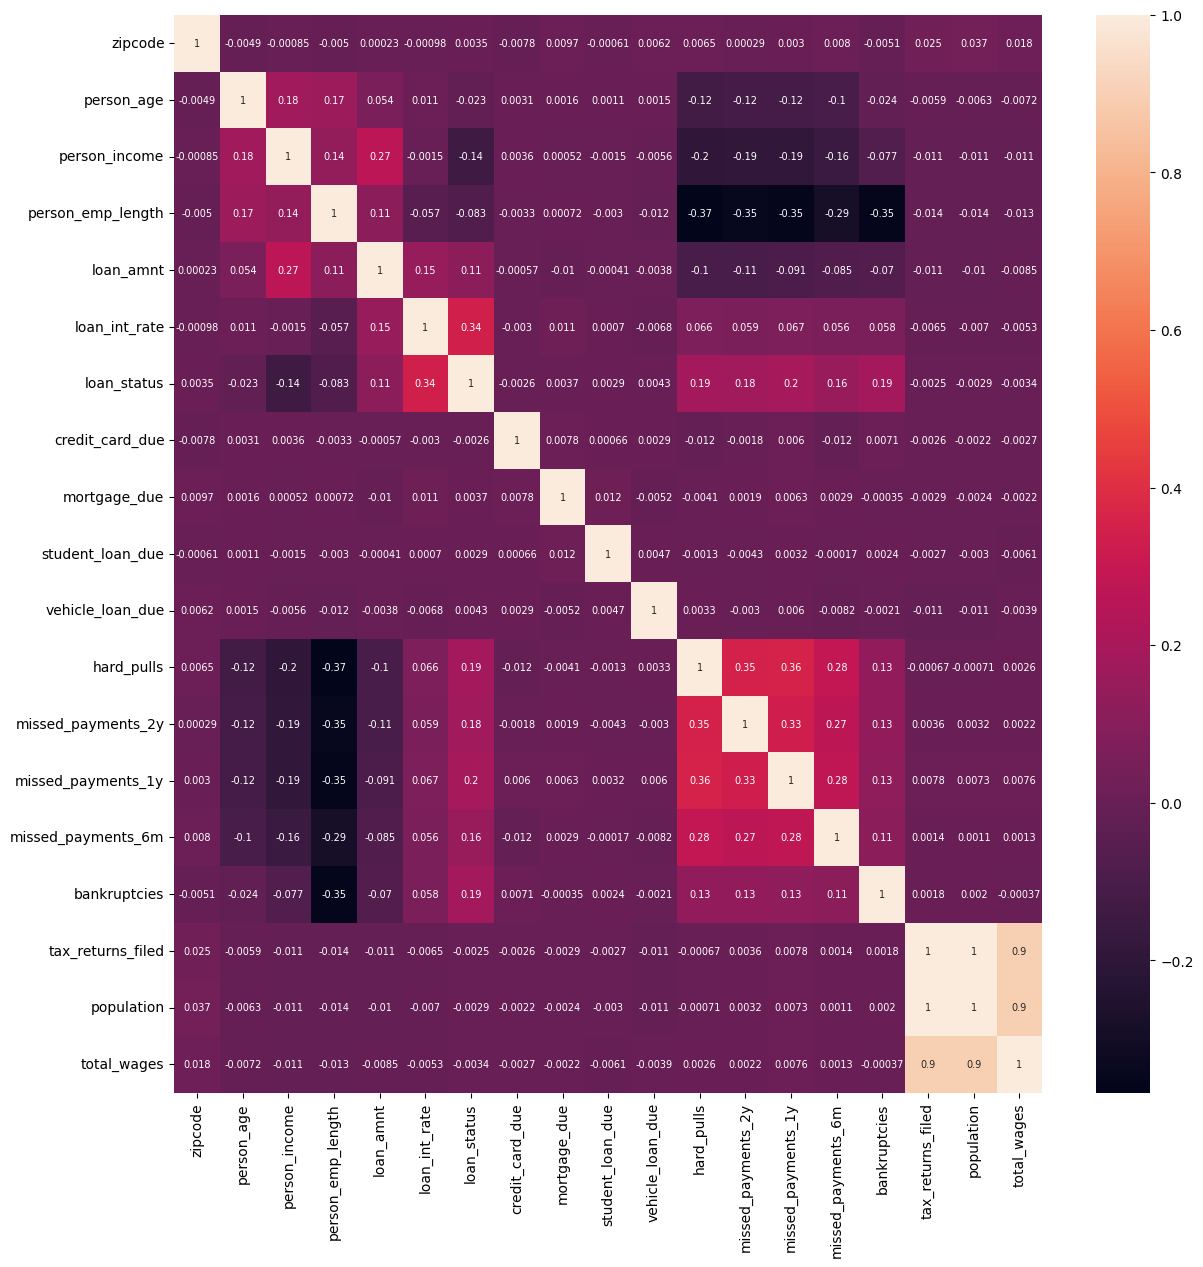

In [9]:

fig, ax = plt.subplots(figsize=(14, 14))
corr = full_dataset.corr(numeric_only=True)
sns.heatmap(corr, annot=True, ax=ax, annot_kws={"fontsize": 7})


## 2. Train XGBoost model to Predict Loan Decision

Next, we take our nicely formatted dataset and feed it to an XGBoost classifier that will make decisions on wether or not the person should receive a loan.

It's important to note that the ``dob_ssn`` and ``zipcode`` are not used in training as they are solely meant as an identifier for lookups. 

In total, the input features to the XGBoost model will be:

- age
- income
- emp_length
- loan_amt
- loan_int_rate
- credit_card_due
- mortgage_due
- student_loan_due
- vehicle_loan_due
- hard_pulls
- missed_payments_2y
- missed_payments_1y
- missed_payments_6m
- bankruptcies
- tax_returns_filed
- population
- total_wages

With the following stored in Redis under the ``dob_ssn`` key:

- credit_card_due
- mortgage_due
- student_loan_due
- vehicle_loan_due
- hard_pulls
- missed_payments_2y
- missed_payments_1y
- missed_payments_6m
- bankruptcies

and the following stored under the ``zipcode`` key

- tax_returns_filed
- population
- total_wages


and lastly, the following features provided in the request body

- age
- income
- emp_length
- loan_amt
- loan_int_rate


In [10]:
# create the training dataset without lookup columns or target feature.
train_y = full_dataset["loan_status"]
train_x = full_dataset.drop(columns=["loan_status", "dob_ssn", "zipcode"])

In [11]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2034008 entries, 0 to 2034007
Data columns (total 17 columns):
 #   Column              Dtype  
---  ------              -----  
 0   person_age          int64  
 1   person_income       int64  
 2   person_emp_length   float64
 3   loan_amnt           int64  
 4   loan_int_rate       float64
 5   credit_card_due     int64  
 6   mortgage_due        int64  
 7   student_loan_due    int64  
 8   vehicle_loan_due    int64  
 9   hard_pulls          int64  
 10  missed_payments_2y  int64  
 11  missed_payments_1y  int64  
 12  missed_payments_6m  int64  
 13  bankruptcies        int64  
 14  tax_returns_filed   int64  
 15  population          int64  
 16  total_wages         int64  
dtypes: float64(2), int64(15)
memory usage: 279.3 MB


In [12]:
# split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, random_state=42)

In [13]:
# Set xgboost params
param = {
    'max_depth': 7,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'objective': 'binary:logistic',  # error evaluation for binary class training
    'eval_metric': ['logloss', 'error', 'auc'],
    'num_class': 1, # the number of classes that exist in this dataset
    'early_stopping_rounds': 2
}

# init and train the model
bst = xgb.XGBClassifier(**param)
bst.fit(X_train.values, y_train.values, verbose=True, eval_set=[(X_test.values, y_test.values)])

# evaluate predictions
preds = bst.predict(X_test.values)
predictions = [round(value) for value in preds]
accuracy = accuracy_score(y_test.values, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[0]	validation_0-logloss:0.52288	validation_0-error:0.11351	validation_0-auc:0.91533
[1]	validation_0-logloss:0.42673	validation_0-error:0.10537	validation_0-auc:0.92812
[2]	validation_0-logloss:0.36558	validation_0-error:0.10267	validation_0-auc:0.93162
[3]	validation_0-logloss:0.32573	validation_0-error:0.09985	validation_0-auc:0.93489
[4]	validation_0-logloss:0.29609	validation_0-error:0.09439	validation_0-auc:0.93958
[5]	validation_0-logloss:0.27418	validation_0-error:0.09058	validation_0-auc:0.94348
[6]	validation_0-logloss:0.25874	validation_0-error:0.08904	validation_0-auc:0.94598
[7]	validation_0-logloss:0.24588	validation_0-error:0.08593	validation_0-auc:0.94948
[8]	validation_0-logloss:0.23548	validation_0-error:0.08333	validation_0-auc:0.95239
[9]	validation_0-logloss:0.22707	validation_0-error:0.08130	validation_0-auc:0.95513
[10]	validation_0-logloss:0.21975	validation_0-error:0.07779	validation_0-auc:0.95734
[11]	validation_0-logloss:0.21249	validation_0-error:0.07558	val

In [14]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

predict_train = bst.predict(X_train)
predict_test = bst.predict(X_test)

print("Train Score:", roc_auc_score(predict_train, y_train))
print("Train error:", mean_squared_error(predict_train,y_train))
print("Test Score:", roc_auc_score(predict_test, y_test))
print("Test error:", mean_squared_error(predict_test,y_test))

Train Score: 0.9909457360981404
Train error: 0.009655157042974594
Test Score: 0.9904703626314693
Test error: 0.010129753668618806


In [15]:
def confusion(y_true, pred, title=None):
    
    matrix = confusion_matrix(y_true, pred)
    plt.figure(figsize = (5,5))
    sns.heatmap(data= matrix, annot=True, cmap='Blues', fmt='g')
    
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(title)
    plt.show

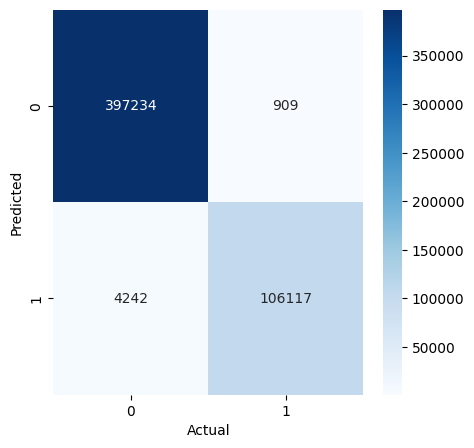

In [16]:
confusion(y_test.values, predict_test) 

In [17]:
from sklearn.metrics import classification_report

print(classification_report(y_test.values, predictions))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    398143
           1       0.99      0.96      0.98    110359

    accuracy                           0.99    508502
   macro avg       0.99      0.98      0.98    508502
weighted avg       0.99      0.99      0.99    508502



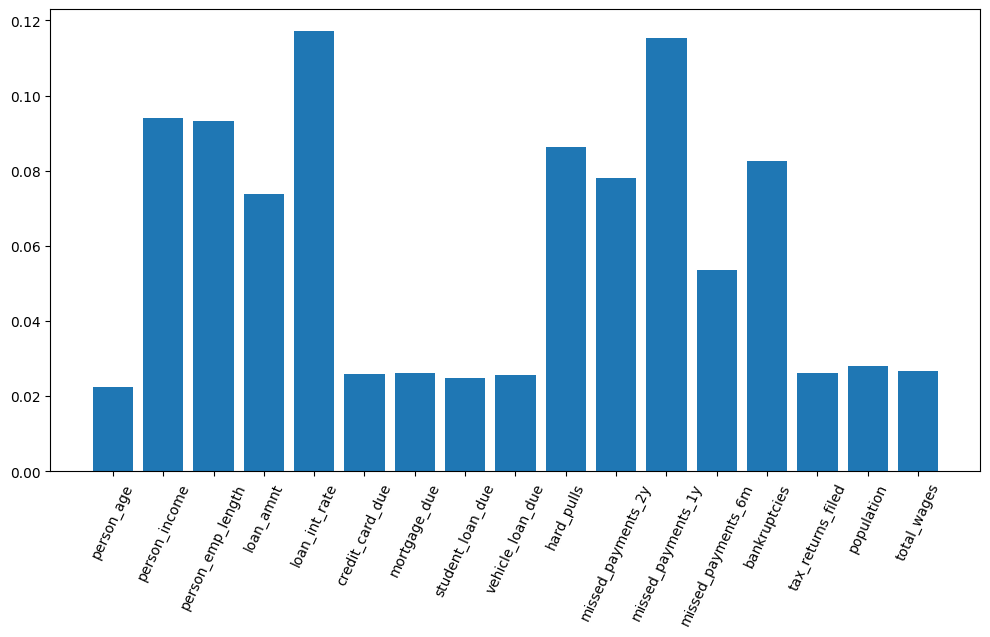

In [18]:
plt.figure(figsize=(12,6))
plt.bar(range(len(bst.feature_importances_)), bst.feature_importances_)
plt.xticks(range(len(bst.feature_importances_)), train_x.columns, rotation=65, fontsize=10)
plt.show()

# 3. Save XGBoost model to ONNX format to Prepare for Deployment

In [19]:
# save the model to disk for later loading into Redis for inference serving.
onnx_model = convert_xgboost(bst, initial_types=[("input", FloatTensorType(shape=[1, 17]))])

In [20]:
with open(f"{DATA_LOCATION}/xgboost_model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [21]:
# test the model with the ONNX inference runtime.
with open(f"{DATA_LOCATION}/xgboost_model.onnx", "rb") as f:
    model_bytes = f.read()
    
sess = InferenceSession(model_bytes)

In [22]:
sess.run(None, {"input": X_train.values[0:1].astype(np.float32)})

[array([0], dtype=int64), array([[0.83850735, 0.16149265]], dtype=float32)]

In [23]:
X_train.values[0:1].astype(np.float32)

array([[2.3000000e+01, 4.4100000e+04, 8.0000000e+00, 1.3000000e+04,
        8.8999996e+00, 7.5770000e+03, 7.6319800e+05, 2.6387000e+04,
        1.8550000e+04, 7.0000000e+00, 7.0000000e+00, 0.0000000e+00,
        1.0000000e+00, 0.0000000e+00, 6.4100000e+02, 1.1620000e+03,
        2.2916256e+07]], dtype=float32)